In [87]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# Force reload of project files
import data, train, models, metrics
importlib.reload(data)
from data import DataLoader


# Params
features_dict = {'daily':['gage_Q'],
                'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']}
target_label = 'tss'
time_slice = slice('2008-01-01', None)
split_time =  np.datetime64('2017-01-01')
num_samples = 10000
sequence_length = 30
batch_size = 256
num_epochs = 50
hidden_size = 8
output_size = 1

data_dir = Path("../data/Sag")

dataloader = DataLoader(data_dir = data_dir,
                        basins = ['sag_daily_data','sag_daily_data_2'],
                        features_dict = features_dict,
                        target = target_label,
                        time_slice = time_slice,
                        split_time = split_time,
                        batch_size = batch_size, 
                        sequence_length = sequence_length,
                        discharge_col = 'gage_Q',
                        zero_min_cols = ['gage_Q','tss'])

In [36]:
dataloader.x_s['sag_daily_data'].shape[0]

1

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

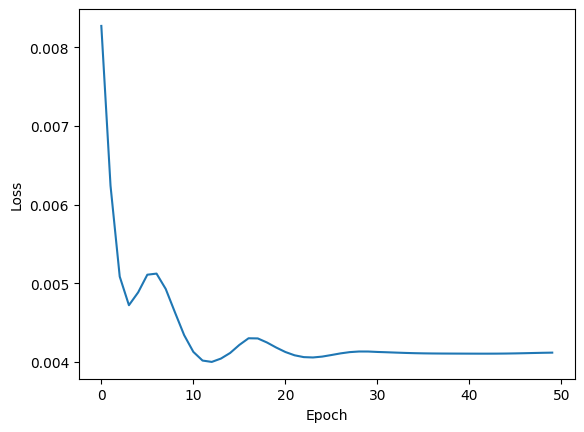

In [88]:
importlib.reload(models)
importlib.reload(train)
from models import TAPLSTM
from train import make_step, lr_dict_scheduler

lr_schedule = { 
    0: 0.01,
    30: 0.005}

# Initialize the model
key = jax.random.PRNGKey(0)
model = TAPLSTM(daily_in_size=len(features_dict['daily']),
                irregular_in_size=len(features_dict['irregular']),
                static_in_size=dataloader.x_s['sag_daily_data'].shape[0],
                out_size=output_size, 
                hidden_size=hidden_size, 
                key=key)

# Initialize optimizer 
current_lr = lr_dict_scheduler(0, lr_schedule)
optim = optax.adam(current_lr)
opt_state = optim.init(model)

# Training loop
loss_list = []
pbar = trange(num_epochs, desc="Epoch")
for epoch in pbar:
    # Update learning rate and optimizer
    current_lr = lr_dict_scheduler(epoch, lr_schedule)
    optim = optax.adam(current_lr)
    
    total_loss = 0
    num_batches = 0
    dataloader.train = True
    for data in dataloader:
        loss, model, opt_state = make_step(model, data, opt_state, optim,
                                           loss_name="if_mse",
                                           max_grad_norm=2,
                                           l2_weight = 1E-4)
        total_loss += loss
        num_batches += 1
        if num_batches * batch_size >= num_samples:
            break
            
    current_loss = total_loss / num_batches
    loss_list.append(current_loss)
    pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

plt.plot(loss_list)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [89]:
import equinox as eqx
# Predict on the test data
predictions = []
ids = []
dataloader.train = False

@eqx.filter_jit
def predict(model, data):
    return jax.vmap(model)(data)
    
for data in tqdm(dataloader):
    # Make predictions for the current batch
    predictions.extend(predict(model,data))

# # Convert lists to arrays
predictions = np.array(predictions).flatten()
# ids = np.array(ids).flatten()

# scale = test_dl.scale
# rescaled_pred = predictions * scale['scale'][target_label] + scale['offset'][target_label]

# # Convert lists to arrays
predictions = np.array(predictions).flatten()
# ids = np.array(ids).flatten()

# rescaled_pred = predictions * scale['scale'][target_label] + scale['offset'][target_label]
# test_df['tss_pred'] = np.nan
# test_df.iloc[ids,-1] = rescaled_pred

  0%|          | 0/17 [00:00<?, ?it/s]

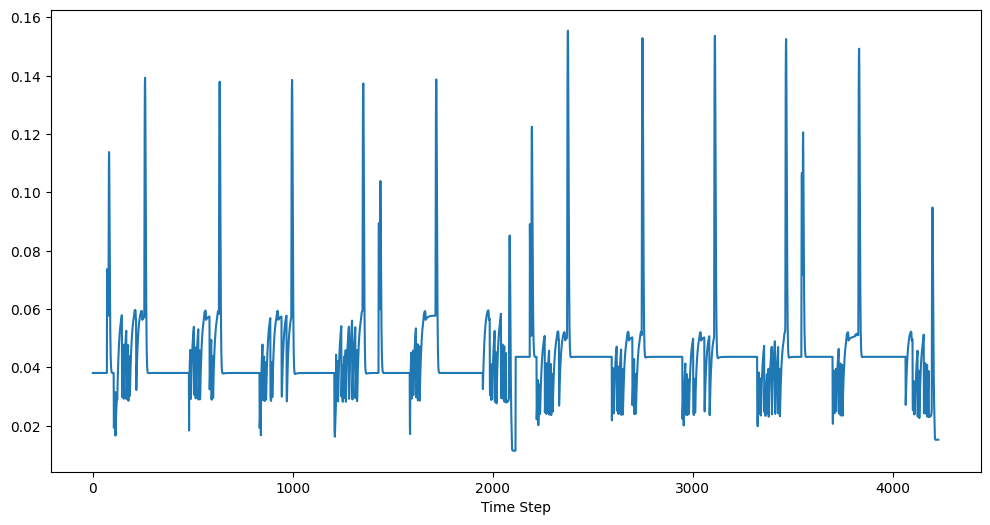

In [90]:
# Plot the true values and predictions
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.plot(predictions)

plt.xlabel('Time Step')
plt.show()